<a href="https://colab.research.google.com/github/albertopolini/DSIM/blob/main/DSIM07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image retrieval

In [1]:
# Keras modules
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2

# Data loading
from shutil import copyfile
import tarfile

# Misc
from matplotlib import pyplot as plt
import numpy as np
import os

In [2]:
copyfile('drive/My Drive/cat500.tar', 'cat500.tar')
tar = tarfile.open('cat500.tar')
tar.extractall()
tar.close()

In [4]:
model = keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    pooling='max'
)

9420800/9406464 [==============================] - 0s 0us/step


In [6]:
img = kimage.load_img('images/cat_spot.jpg', target_size=(224,224))

In [7]:
type(img)

PIL.Image.Image

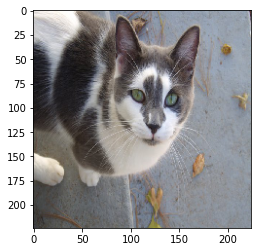

In [8]:
plt.imshow(img)

In [9]:
# Convertion from Pillow to numpy

x = kimage.img_to_array(img)

In [11]:
type(x)

numpy.ndarray

In [12]:
print((x.min(), x.max()))
print(x.shape)

(7.0, 255.0)
(224, 224, 3)


In [13]:
 x = keras.applications.mobilenet_v2.preprocess_input(x)

print((x.min(), x.max()))
print(x.shape)

(-0.94509804, 1.0)
(224, 224, 3)


In [14]:
# Adding a dimension at the beginning of the array. This encode the information relative to the batch

x = np.expand_dims(x, axis = 0)

In [15]:
features = model.predict(x)

In [17]:
features.shape

(1, 1280)

In [18]:
# Data loader

# Debug variable to limit the number of loaded images
maximages = 500

# Dummy feature
def identity(image):
    return kimage.img_to_array(img).flatten()

# Data loader
def load_data(feature_extractor=identity):
    base_path = 'images/cat500/'

    paths = []
    features = []

    for fi,f in enumerate(sorted(os.listdir(base_path))):
        if f.endswith('.jpg') and fi<maximages:
            # Save file path
            cur_path = base_path + f
            paths.append(cur_path)
            
            # Load file and extract features
            image = kimage.load_img(cur_path, target_size=(224, 224))
            cur_features = feature_extractor(image)
            features.append(cur_features)

    features = np.array(features)
    return features, paths

In [20]:
def neural_features(img):
  x = kimage.img_to_array(img)
  x = keras.applications.mobilenet_v2.preprocess_input(x)
  x = np.expand_dims(x, axis = 0)

  f = model.predict(x)
  f = f.flatten()

  return f

In [21]:
X_train, paths = load_data(feature_extractor=neural_features)

In [22]:
len(paths)

500

In [24]:
X_train.shape

(500, 1280)

## KDTree
We will use a data structure to speed up the processing 

In [30]:
from sklearn.neighbors import KDTree

tree = KDTree(X_train)

In [49]:
query_img  = kimage.load_img('images/cat_spot.jpg', target_size=(224,224))

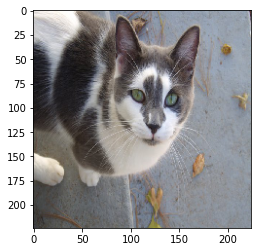

In [50]:
plt.imshow(query_img)

In [51]:
query_features = neural_features(query_img)

In [52]:
query_features = np.expand_dims(query_features, axis=0)

In [53]:
dist, ind = tree.query(query_features, k=1)

In [54]:
print(f"dist:{dist} ind:{ind}")

dist:[[88.8262698]] ind:[[406]]


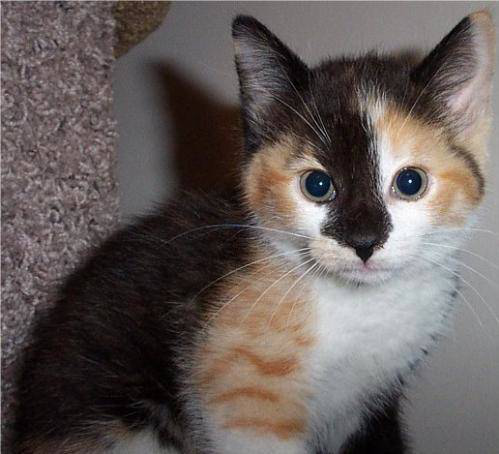

In [55]:
kimage.load_img(paths[ind[0][0]])

In [56]:
import joblib
joblib.dump(tree, 'cat_kdtree.joblib')

['cat_kdtree.joblib']

In [57]:
tree = None

In [59]:
tree = joblib.load('cat_kdtree.joblib')